In [1]:
# basic imports
import pandas as pd, matplotlib.pyplot as plt, numpy as np 
import IPython.display as ipd

In [2]:
# librosa - for CQT and visualisation
import librosa, librosa.display

In [3]:
# Interval for label storage
from intervaltree import Interval,IntervalTree

# Neural Network attempt

## Import data

In [4]:
# import h5py to read in hdf5 files 
import h5py

filename ='musicnet.h5'
music_net = h5py.File(filename,'r')
type(music_net)

h5py._hl.files.File

In [5]:
# # find the keys 
list(music_net.keys())[0:5]

['id_1727', 'id_1728', 'id_1729', 'id_1730', 'id_1733']

In [6]:
list(music_net['id_1730'].keys())

['data', 'labels']

In [7]:
# grab song id_1730
song = music_net['id_1730']
music = song['data'][()]
Y = song['labels'][()]

### audio data

In [8]:
# sampling rate
sr = 44100
sr_16k = 16000

# resample to 16kHz
music = librosa.resample(music,sr,sr_16k)

In [9]:
# CQT parameters
sr_16k = 16000 # downsampling to 16kHz
hop_length = 512 # 32ms frames  
bins_per_octave = 36 # corresponds to 7 octaves on the piano 
n_bins = 252 # frequency resolution 

# CQT 
C_proto = np.abs(librosa.cqt(music,sr = sr_16k , \
                 hop_length=hop_length, bins_per_octave = bins_per_octave,
                 window='hann',n_bins = n_bins))
# how many frames in this file ? 
frame_no = C_proto.shape[1]
frame_no

11517

In [10]:
C_proto.shape

(252, 11517)

In [11]:
X_proto = np.transpose(C_proto)
X_proto.shape

(11517, 252)

### labels

In [12]:
Y.dtype

dtype([('beat', '<f4'), ('end_time', '<u4'), ('instrument_id', 'u1'), ('measure', '<u4'), ('note_id', 'u1'), ('note_value', 'S32'), ('start_time', '<u4')])

In [13]:
# set up params for labels 
number_of_notes = 88 
number_frames = X_proto.shape[0]
number_frames

11517

In [14]:
# binary labels 
binary_labels = np.zeros((number_frames, number_of_notes))
binary_labels.shape

(11517, 88)

In [15]:
# init tree for slicing
labels_tree = IntervalTree()
for label in Y: 
    pitch = label['note_id']
    start_time = label['start_time']
    end_time = label['end_time']
    # insert
    labels_tree.addi(start_time,end_time,pitch)

In [16]:
# sample labels accordingly  
wps = sr_16k/float(hop_length) # windows per second 
for window in range(binary_labels.shape[0]):
    # check what notes are active
    labels = labels_tree.at(window*hop_length)
    # loop through all the labels 
    for label in labels:
        # keep the pitch in the range 0-87 
        pitch = label[2]-21 
        # if this pitch is active in this window 
        binary_labels[window,pitch] = 1

In [52]:
df = pd.DataFrame(binary_labels)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


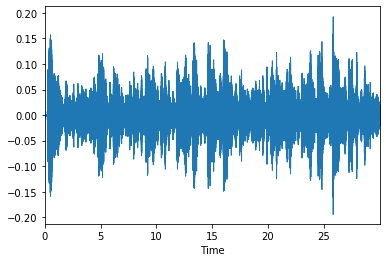

In [18]:
# display first 30 seconds of audiofile  
librosa.display.waveplot(music[0:30*sr_16k], sr = sr_16k)

In [19]:
# play the audio file 
ipd.Audio(music[0:30*sr_16k],rate=sr_16k)

### train, validation, test split
- 60% train, 20% validation, 20% test 
- validation set is for hyperparameter tuning 

In [20]:
from sklearn.model_selection import train_test_split

X = X_proto
y = binary_labels

# split into train, test and validation 
# X_train_val, X_test, y_train_val, y_test = train_test_split(X_proto, y, test_size = 0.2, random_state=42)
# # need to set split = 0.25 to get 60-20-20 split 
# X_train, X_val, y_train, y_val = train_test_split(X_train_validation,y_train_val, test_size=0.25, random_state=42)

## Preprocessing
1. downsample audio signal from 44.1kHz to 16kHz
 - 512 samples/frame -> 32ms frame
2. CQT transformation 
 - number of bins per octave is 36 
 - number of features is 252 per frame
3. frames of all data are grouped into 40000 frames per file for each set - this might be different
4. validation and test sets are normalized by subtracting the mean of the training set
5. Multilabel one hot representation for labels - might be different 
6. sample ground truth at 31.25 frames per second - might be different
7. Stack and split piano note frame vectors into 40000 frames per file to align with the input matrix - might be different

In [21]:
# # downsample to enhance efficiency of CQT 
# sr_16k = 16000
# X_train = librosa.resample(X_train,sr,sr_16k)
# X_val = librosa.resample(X_val,sr,sr_16k)
# X_test = librosa.resample(X_test,sr,sr_16k)

In [22]:
# 31.25 frames per second 
# 31.25*512

In [23]:
# # CQT transform
# samples_per_frame = 512
# bins_per_octave = 36

# # calling cqt transform
# C_train = librosa.cqt(X_train, sr = sr_16k , \
#                  hop_length=samples_per_frame, bins_per_octave = bins_per_octave,
#                 \ window='hann')
# C_val = librosa.cqt(X_val, sr = sr_16k , \
#                  hop_length=samples_per_frame, bins_per_octave = bins_per_octave,
#                 \ window='hann')
# C_test = librosa.cqt(X_test, sr = sr_16k , \
#                  hop_length=samples_per_frame, bins_per_octave = bins_per_octave,
#                 \ window='hann')

In [24]:
# # normalization

# # find mean 
# mean_training = np.mean(C_train)

# # subtract mean 
# C_val = C_val - mean_training 
# C_test = C_test - mean_training 

## Define model 
1. Activation functions : hidden - ReLU, output - sigmoid 
2. Loss function : binary cross entropy 
3. Optimizer : adam 
4. Learning rate : 0.1
5. Mini-batch size : 400
6. Layers : input - 252, hidden - 256, output - 88
7. Early stop : patience - 20 

In [25]:
# import keras deep learning models  
from keras.layers import Dense, Dropout
from keras.models import Sequential 

layers = 3 
hidden_nodes = 256
num_col = n_bins
output_nodes =number_of_notes

# input layer
# model type 
model = Sequential()

# specify features 
model.add(Dense(num_col,activation='relu',input_shape=(num_col,)))
# add dropout
model.add(Dropout(0.2))

# hidden layers 
# add hidden layer
for i in range(layers): 
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    
# output layer
# 88 nodes for 88 midi notes 
# sigmoid activation function
model.add(Dense(number_of_notes, activation='sigmoid'))

Using TensorFlow backend.
W0911 18:10:38.470880 37808 deprecation_wrapper.py:119] From C:\Users\olli\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0911 18:10:38.501609 37808 deprecation_wrapper.py:119] From C:\Users\olli\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 18:10:38.506596 37808 deprecation_wrapper.py:119] From C:\Users\olli\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0911 18:10:38.535521 37808 deprecation_wrapper.py:119] From C:\Users\olli\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0911 18:10:38.552645 37

### Compilation

In [26]:
# define 3 metrics
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [27]:
# import adam optimizer
from keras.optimizers import Adam 

# instantiate optimizer with lr = learning rate of 0.1  
optimizer = Adam(lr=0.1)
# compile model - with accuracy, mean_absoluted error and f1 measure metrics
model.compile(optimizer=optimizer,\
              loss='binary_crossentropy',
             metrics=['acc',f1_m])

W0911 18:10:38.872517 37808 deprecation_wrapper.py:119] From C:\Users\olli\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0911 18:10:38.885571 37808 deprecation_wrapper.py:119] From C:\Users\olli\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0911 18:10:38.899645 37808 deprecation.py:323] From C:\Users\olli\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Fit the model

In [28]:
# import early stop 
from keras.callbacks import EarlyStopping
# patience = 20 
early_stopping_monitor = EarlyStopping(patience=5)
# fit the model
history = model.fit(X,y,validation_split = 0.2, \
                    epochs = 1000, batch_size=400,\
                    callbacks=[early_stopping_monitor], verbose = 1)
history 

Train on 9213 samples, validate on 2304 samples
Epoch 1/1000
9213/9213 [==============================] - 3s 288us/step - loss: 0.6398 - acc: 0.9398 - f1_m: 0.0029 - val_loss: 1.0528 - val_acc: 0.9347 - val_f1_m: 0.0000e+00
Epoch 2/1000
9213/9213 [==============================] - 1s 67us/step - loss: 0.6387 - acc: 0.9604 - f1_m: 0.0000e+00 - val_loss: 1.0528 - val_acc: 0.9347 - val_f1_m: 0.0000e+00
Epoch 3/1000
9213/9213 [==============================] - 1s 68us/step - loss: 0.6387 - acc: 0.9604 - f1_m: 0.0000e+00 - val_loss: 1.0528 - val_acc: 0.9347 - val_f1_m: 0.0000e+00
Epoch 4/1000
9213/9213 [==============================] - 1s 67us/step - loss: 0.6387 - acc: 0.9604 - f1_m: 0.0000e+00 - val_loss: 1.0528 - val_acc: 0.9347 - val_f1_m: 0.0000e+00
Epoch 5/1000
9213/9213 [==============================] - 1s 61us/step - loss: 0.6387 - acc: 0.9604 - f1_m: 0.0000e+00 - val_loss: 1.0528 - val_acc: 0.9347 - val_f1_m: 0.0000e+00
Epoch 6/1000
9213/9213 [==============================] - 1s

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 252)               63756     
_________________________________________________________________
dropout_1 (Dropout)          (None, 252)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               64768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

### interpreting features 

In [30]:
model.predict(X).nonzero()

(array([], dtype=int64), array([], dtype=int64))